In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix
from tqdm.autonotebook import tqdm

import bandit.environment as env
from bandit.policy import EGreedy, Softmax
from bandit.tensorflow import NeuralBandit, NeuralBanditPerArm, create_models
from bandit.utils import snapshot

sns.set_theme()

/var/folders/7m/74_ct3hx33d878n626w1wxyc0000gn/T/ipykernel_7556/3225486162.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/var/folders/7m/74_ct3hx33d878n626w1wxyc0000gn/T/ipykernel_7556/3225486162.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
2024-02-05 23:37:26.474348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruction

In [2]:
import keras

keras.__version__

'2.15.0'

In [3]:
N = 500


def run_simulation(bandit, policy, n=N, dynamic=False):
    total_reward = 0
    avg_rewards = []
    rng = np.random.RandomState(42)

    for i in tqdm(range(n), disable=False):
        state = env.observe(rng)

        # 1. Predict the action.
        rewards = bandit.pull(state)

        action = policy(rewards)

        # 2. Act and get the reward.
        if dynamic and i > n // 2:
            get_cost = env.get_cost_new
        else:
            get_cost = env.get_cost
        reward = get_cost(state, env.actions[action])

        # 3. Update the model.
        bandit.update(state, action, reward)

        # 4. Save the reward.
        total_reward += max(0, reward)
        avg_rewards.append(total_reward / (i + 1))
    return avg_rewards, total_reward

In [4]:
policy = EGreedy(epsilon=0.0)
bandit = NeuralBandit(n_arms=len(env.actions), batch=1)

avg_rewards, total_reward = run_simulation(bandit, policy, n=N, dynamic=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:13<00:00,  6.78it/s]


In [5]:
total_reward

215.0

In [6]:
rng = np.random.RandomState(42)
state = env.observe(rng)
state

{'user': 'Tom', 'time_of_day': 'afternoon'}

In [7]:
env.actions[policy(bandit.pull(state))]

'food'

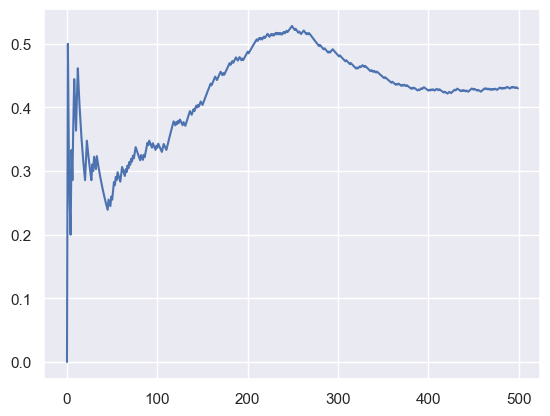

In [8]:
plt.plot(range(N), avg_rewards)

Why is the tensorflow version performing worse than the scikit-learn MultiLayerPerceptron? The example has been modified to ue the `one_hot_encoding` instead of `feature_interaction`, but the result is still the same.

How about the pytorch version?

## Per-arm Bandit

In [ ]:
policy = EGreedy(epsilon=0.0)
bandit = NeuralBanditPerArm(batch=1, models=create_models(len(env.actions)))

avg_rewards, total_reward = run_simulation(bandit, policy, n=N, dynamic=True)

  0%|                                                                                                                          | 0/500 [00:00<?, ?it/s]

  1%|█▌                                                                                                                | 7/500 [00:05<05:16,  1.56it/s]

 52%|██████████████████████████████████████████████████████████▏                                                     | 260/500 [02:26<02:04,  1.92it/s]

In [ ]:
total_reward

In [ ]:
plt.plot(range(N), avg_rewards)